In [3]:
import sys
root_path = "/Users/sa/CS/stanford/cs229/Project/Neural-Response-Generator-augmented-with-psychological-personalities/"

import pandas as pd
import autoreload
import sys
sys.path.append(root_path + "library/")

%load_ext autoreload
%autoreload 2

# Data preprocessing custom package
import text_preprocessing
from text_preprocessing import Preprocessor

# essentials
import numpy as np
from tqdm.notebook import tqdm
import pickle

[nltk_data] Downloading package wordnet to /tmp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /tmp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /tmp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /tmp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocess Data

In [4]:
preprocess = False
seperate_user_post = False
groupid = 0

if preprocess:
    # Initialize preprocessing class
    pt = Preprocessor()
    
    # load Orginal MBTI Raw data
    df = pd.read_csv(root_path + "data/raw/mbti_1.csv")
    data = pd.DataFrame(columns=['groupid','type', 'post'])
    
    if not seperate_user_post:
        for itr, row in tqdm(df.iterrows(), total=df.shape[0], mininterval=30):
            post_list = row[1].split("|||")
            sent_list_preprocessed = pt.get_preprocessed_text(". ".join(post_list), lemma=True, stop_words=True, remove_punct=True, mask_numbers=True, sentence_quality=True)
            if len(sent_list_preprocessed) >= 0:
                data.loc[data.shape[0]+1] = [groupid, row[0], ". ".join(sent_list_preprocessed)]
            groupid += 1
        
        data.to_pickle(root_path + "data/processed/final/MBTI_preprocessed_v1.pkl")

    else:
        for itr, row in tqdm(df.iterrows(), total=df.shape[0], mininterval=30):
            post_list = row[1].split("|||")
            post_list_preprocessed = pt.get_preprocessed_text(post_list, lemma=True, stop_words=True, remove_punct=True, mask_numbers=True, sentence_quality=True)
            if len(post_list_preprocessed) >= 0:
                for post in post_list_preprocessed:
                    if len(post.split(". ")) >=2 or len(post.split(" ")) >= 40:
                        data.loc[data.shape[0]+1] = [groupid, row[0], sent]
            groupid += 1


        data.to_pickle(root_path + "data/processed/final/MBTI_preprocessed_v1.pkl")

else:
  # load the preprocessed Dataset
    data = pd.read_pickle(root_path + "data/processed/final/MBTI_preprocessed_v1.pkl")

/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


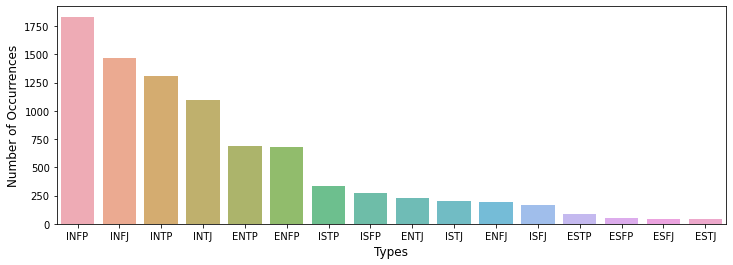

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [22]:
# convert personality type from string to int
labels = data['type'].unique()

label_dict = {}
index_label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
    index_label_dict[index] = label
    
# add label column to the data
data['label'] = data['type'].replace(label_dict)

In [24]:
#pickle.dump(index_label_dict, open(root_path + "models/final/label_dict.pkl","wb"))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=data.label.values)

data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

data.groupby(['type', 'label', 'data_type']).count()

groupid  post
type label data_type               
ENFJ 5     train          152   152
           val             38    38
ENFP 7     train          540   540
           val            135   135
ENTJ 4     train          185   185
           val             46    46
ENTP 1     train          548   548
           val            137   137
ESFJ 15    train           34    34
           val              8     8
ESFP 13    train           38    38
           val             10    10
ESTJ 14    train           31    31
           val              8     8
ESTP 12    train           71    71
           val             18    18
INFJ 0     train         1176  1176
           val            294   294
INFP 6     train         1465  1465
           val            367   367
INTJ 3     train          873   873
           val            218   218
INTP 2     train         1043  1043
           val            261   261
ISFJ 10    train          133   133
           val             33    33
ISFP 8     train          217   217
           val             54    54
ISTJ 11    train          164   164
           val             41    41
ISTP 9     train          270   270
           val             67    67

# Feature Engineering

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

cvectorizer = CountVectorizer(analyzer="word", 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             ngram_range=(1,3)) 

vectorizer = TfidfTransformer(use_idf=True, sublinear_tf=True)

corpus = list(data['post'])
corpus_cnt = cvectorizer.fit_transform(corpus)

vocabulary = vectorizer.fit_transform(corpus_cnt) 

X_train_vec = vectorizer.transform(cvectorizer.transform(list(data.loc[X_train]['post'])))
X_val_vec = vectorizer.transform(cvectorizer.transform(list(data.loc[X_val]['post'])))

In [8]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
vocab_red_svd = svd.fit_transform(vocabulary)

In [18]:
# To use the vectorizer during inference.
pickle.dump(cvectorizer, open(root_path + "models/final/cvectorizer.pkl","wb"))
pickle.dump(vectorizer, open(root_path + "models/final/vectorizer.pkl","wb"))
pickle.dump(svd, open(root_path + "models/final/tsvd.pkl","wb"))

In [11]:
from sklearn.manifold import TSNE

print("TSNE")
X_tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=650).fit_transform(vocab_red_svd)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8675 samples in 0.005s...
[t-SNE] Computed neighbors for 8675 samples in 1.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8675
[t-SNE] Computed conditional probabilities for sample 2000 / 8675
[t-SNE] Computed conditional probabilities for sample 3000 / 8675
[t-SNE] Computed conditional probabilities for sample 4000 / 8675
[t-SNE] Computed conditional probabilities for sample 5000 / 8675
[t-SNE] Computed conditional probabilities for sample 6000 / 8675
[t-SNE] Computed conditional probabilities for sample 7000 / 8675
[t-SNE] Computed conditional probabilities for sample 8000 / 8675
[t-SNE] Computed conditional probabilities for sample 8675 / 8675
[t-SNE] Mean sigma: 0.011414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.208649
[t-SNE] KL divergence after 650 iterations: 1.930266


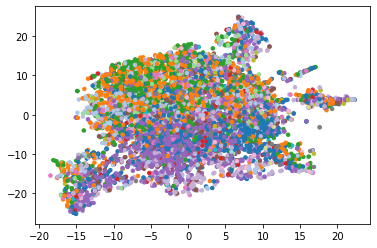

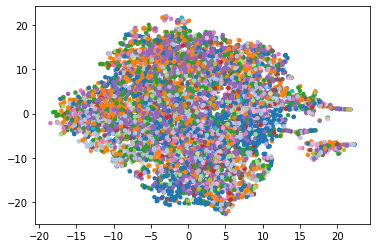

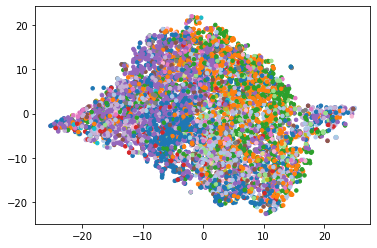

In [13]:
from matplotlib import legend
col = data.label.values
plt.figure(0)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(1)
plt.scatter(X_tsne[:,0], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(2)
plt.scatter(X_tsne[:,1], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)

In [9]:
print ("Before reduction, dim of training and val set: ", X_train_vec.shape[1],"  ", X_val_vec.shape[1])
X_train_vec_red_svd = svd.transform(X_train_vec)
X_val_vec_red_svd = svd.transform(X_val_vec)
print ("After reduction, dim of training and val set: ", X_train_vec_red_svd.shape[1]," ", X_val_vec_red_svd.shape[1])

Before reduction, dim of training and val set:  4608257    4608257
After reduction, dim of training and val set:  100   100


In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_train_sampled, y_train_sampled = smote.fit_sample(X_train_vec_red_svd, y_train)
X_val_sampled, y_val_sampled = smote.fit_sample(X_val_vec_red_svd, y_val)

In [11]:
print ("before resampling, samples of training and val set: ", X_train_vec_red_svd.shape[0], "  ", X_val_vec_red_svd.shape[0])
print ("after resampling, samples of training and val set: ", X_train_sampled.shape[0], "  ", X_val_sampled.shape[0])

before resampling, samples of training and val set:  6940    1735
after resampling, samples of training and val set:  23440    5872


In [12]:
#np.save(open(root_path + "data/intermediate/final/MBTI_features.pkl", "wb"), np.asarray([X_train_vec_red_svd, X_val_vec_red_svd, y_train, y_val]))
np.save(open(root_path + "data/intermediate/final/MBTI_features.pkl", "wb"), np.asarray([X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled]))

/Users/sa/.venv/dl/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
